In [4]:
# Import statements

import cv2
import os
import numpy as np
import pandas as pd
import fnmatch
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, LeaveOneOut, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, make_scorer, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
# Video data path
data_path = '/Users/saiyanaramisetty/LJMU/Coding/Data'

In [286]:
# Dataset length
pet_len = len(fnmatch.filter(os.listdir(data_path + "/Pet"),'*.avi'))
play_len = len(fnmatch.filter(os.listdir(data_path + "/Play"),'*.avi'))
walk_len = len(fnmatch.filter(os.listdir(data_path + "/Walk"),'*.avi'))
watch_len = len(fnmatch.filter(os.listdir(data_path + "/Watch"),'*.avi'))
feed_len = len(fnmatch.filter(os.listdir(data_path + "/Feed"),'*.avi'))
total_len = pet_len + play_len + walk_len + watch_len + feed_len
print(pet_len, play_len, walk_len, watch_len, feed_len, total_len)

25 13 25 19 25 107


In [1]:
classes_to_consider = ['Pet', 'Play', 'Feed']
class_labels_dictionary = {'Pet': 0, 'Play': 1, 'Feed': 2}

In [4]:
# Common methods
def get_input_data(features_path, storage_path, classes_to_consider):
    data_list = os.listdir(features_path)
    if '.DS_Store' in data_list : data_list.remove('.DS_Store')
        
    input_data = pd.DataFrame()
        
    for i, j in enumerate(data_list):
        if j.split('_')[0] in classes_to_consider:
            if i != 0:
                temp_df = pd.read_csv(features_path + j)
                input_data = input_data.append(temp_df)
            else:
                input_data = pd.read_csv (features_path + j)
    
    file_name = storage_path + "input_data.csv"
    input_data.to_csv(file_name, index = False, header = True)
    
    return input_data

# HOG Feature Extraction

In [5]:
def generate_HOG_descriptors(data_path, HOG_path, features_path, frames_bucket_size, classes_to_consider):
    for out_class in classes_to_consider:
        data_list = os.listdir(data_path + out_class + "/")
        if '.DS_Store' in data_list : data_list.remove('.DS_Store')
        
        for i in data_list:
            vc = cv2.VideoCapture(data_path + out_class + "/" + i)
            
            # Capturing the length of the video
            property_id = int(cv2.CAP_PROP_FRAME_COUNT)
            num_frames = int(cv2.VideoCapture.get(vc, property_id))
            
            # Splitting the video into buckets to fetch the frame index
            index_bucket = np.linspace(12, num_frames - 2, frames_bucket_size)
            
            # Initialize a list to store the HOG features
            feature_list = []
            
            for j in range(0, frames_bucket_size):
                vc.set(cv2.CAP_PROP_POS_FRAMES, int(np.floor(index_bucket)[j]))
                ret, frame = vc.read()
                
                # Resize the frame
                resized_frame = resize(frame, (64, 128))
                
                # Extracting HOG features
                hog_feature, hog_image = hog(resized_frame, 
                                             orientations = 9, 
                                             pixels_per_cell = (16, 16), 
                                             cells_per_block = (1, 1), 
                                             visualize = True, 
                                             multichannel = True)
                
                # Appending the frame feature to the video's HOG feature list
                feature_list.append(hog_feature)
                
            # HOG feature array for the video
            HOG_features = np.array(feature_list)
            
            # Combined features
            video_features = HOG_features.reshape(1, -1)
            
            # Appending the class label
            video_features = np.column_stack((video_features, [class_labels_dictionary.get(i.split('_')[0])]))
            
            
            # Store the HOG_features of the video to a file
            file_name = features_path + i.split('.')[0] + ".csv"
            pd.DataFrame(video_features).to_csv(file_name, index = False, header = True)
            
            vc.release()
            cv2.destroyAllWindows()

In [6]:
generate_HOG_descriptors("/Users/saiyanaramisetty/LJMU/Coding/Data/", 
              "/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/", 
              "/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/features_data/",
              5, 
              classes_to_consider)

In [290]:
input_data_hog = get_input_data("/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/features_data/",
                            "/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/",
                            classes_to_consider)

In [5]:
input_data_hog = pd.read_csv("/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/input_data.csv")

In [6]:
input_data_hog.rename(columns = lambda x: 'feature_' + x, inplace = True)
input_data_hog.rename(columns = {'feature_' +  str(len(input_data_hog.columns) - 1) :'class_label'}, inplace = True)
input_data_hog['class_label'] = input_data_hog['class_label'].astype(int)

In [7]:
input_data_hog.head

<bound method NDFrame.head of     feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    0.441139   0.441139   0.441139   0.441139   0.441139   0.075769   
1    0.307176   0.426372   0.426372   0.045397   0.384116   0.426372   
2    0.279578   0.089482   0.187906   0.222473   0.470457   0.470457   
3    0.077249   0.030696   0.098439   0.023516   0.552938   0.573136   
4    0.103350   0.007817   0.002421   0.024605   0.426864   0.627701   
..        ...        ...        ...        ...        ...        ...   
58   0.350732   0.350732   0.350732   0.350732   0.350732   0.350732   
59   0.357079   0.267787   0.357079   0.357079   0.357079   0.357079   
60   0.387082   0.164854   0.387082   0.387082   0.387082   0.219068   
61   0.314868   0.234153   0.170283   0.396252   0.396252   0.396252   
62   0.347161   0.347161   0.347161   0.347161   0.347161   0.333036   

    feature_6  feature_7  feature_8  feature_9  ...  feature_1431  \
0    0.125258   0.037915   0.064153 

In [8]:
input_data_hog['class_label'].value_counts()

2    25
0    25
1    13
Name: class_label, dtype: int64

In [9]:
# splitting into X and y
X = input_data_hog.drop("class_label", axis = 1)
y = input_data_hog.class_label.values.astype(int)

In [10]:
X = scale(X)

In [11]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

# SIFT Feature Extraction

In [23]:
def generate_SIFT_descriptors(data_path, SIFT_path, features_path, frames_bucket_size, classes_to_consider):
    for out_class in classes_to_consider:
        data_list = os.listdir(data_path + out_class + "/")
        if '.DS_Store' in data_list : data_list.remove('.DS_Store')
        
        for i in data_list:
            vc = cv2.VideoCapture(data_path + out_class + "/" + i)
            
            # Capturing the length of the video
            property_id = int(cv2.CAP_PROP_FRAME_COUNT)
            num_frames = int(cv2.VideoCapture.get(vc, property_id))
            
            # Splitting the video into buckets to fetch the frame index
            index_bucket = np.linspace(12, num_frames - 2, frames_bucket_size)
            
            # SIFT Descriptor - Fetching 5 best keypoints
            sift = cv2.SIFT_create(nfeatures = 5)
            
            # Initialize a dataframe to store the SIFT features
            feature_list = pd.DataFrame()
            
            for j in range(0, frames_bucket_size):
                vc.set(cv2.CAP_PROP_POS_FRAMES, int(np.floor(index_bucket)[j]))
                ret, frame = vc.read()
                
                # Converting the image to grayscale
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                
                # Extracting SIFT features
                keypoints, descriptors = sift.detectAndCompute(gray_frame, None)
                if descriptors is None:
                    vc.set(cv2.CAP_PROP_POS_FRAMES, int(np.floor(index_bucket)[j] + 1))
                    ret, frame = vc.read()
                    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    keypoints, descriptors = sift.detectAndCompute(gray_frame, None)

                descriptors = descriptors[:5, :]
                
                # Reshaping the descriptors (1 * n*128)
                descriptors = descriptors.reshape(1, -1)
                
                # Appending the frame feature to the video's SIFT feature list
                feature_list = feature_list.append(pd.DataFrame(descriptors))
            
            # Combined features
            video_features = feature_list.to_numpy().reshape(1, -1)
            
            # Appending the class label
            video_features = np.column_stack((video_features, [class_labels_dictionary.get(i.split('_')[0])]))
            
            # Store the SIFT_features of the video to a file
            file_name = features_path + i.split('.')[0] + ".csv"
            pd.DataFrame(video_features).to_csv(file_name, index = False, header = True)
            
            vc.release()
            cv2.destroyAllWindows()

In [307]:
generate_SIFT_descriptors("/Users/saiyanaramisetty/LJMU/Coding/Data/", 
              "/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/", 
              "/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/features_data/",
              5, 
              classes_to_consider)

In [25]:
input_data_sift = get_input_data("/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/features_data/",
                            "/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/",
                            classes_to_consider)

In [26]:
input_data_sift.shape

(63, 3201)

In [18]:
input_data_sift = pd.read_csv("/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/input_data.csv")

In [19]:
input_data_sift.rename(columns = lambda x: 'feature_' + x, inplace = True)
input_data_sift.rename(columns = {'feature_' +  str(len(input_data_sift.columns) - 1) :'class_label'}, inplace = True)
input_data_sift['class_label'] = input_data_sift['class_label'].astype(int)

In [20]:
input_data_sift.head

<bound method NDFrame.head of     feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        47.0        9.0        1.0        0.0        0.0        0.0   
1        72.0       13.0        0.0        0.0        0.0        0.0   
2        13.0        3.0        0.0        0.0        0.0        2.0   
3         0.0        0.0        0.0        0.0        0.0        0.0   
4         4.0       21.0        6.0        0.0        0.0       35.0   
..        ...        ...        ...        ...        ...        ...   
58        6.0        6.0        2.0        0.0        0.0        0.0   
59        0.0        0.0        0.0        0.0        4.0        4.0   
60        0.0        0.0        0.0        3.0       23.0        5.0   
61       12.0       23.0       12.0        0.0        0.0        0.0   
62       72.0       62.0        0.0        0.0        0.0        0.0   

    feature_6  feature_7  feature_8  feature_9  ...  feature_3191  \
0        29.0      137.0       37.0 

In [21]:
input_data_sift['class_label'].value_counts()

2    25
0    25
1    13
Name: class_label, dtype: int64

In [22]:
input_data_sift = input_data_sift[~input_data_sift.isin([np.nan, np.inf, -np.inf]).any(1)]

In [23]:
# splitting into X and y
X = input_data_sift.drop("class_label", axis = 1)
y = input_data_sift.class_label.values.astype(int)

In [24]:
X = scale(X)

In [25]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

# Combining both HOG (Temporal) and SIFT (Spatial) features

In [72]:
def combine_hog_sift_features(hog_path, sift_path, combined_path):
    data_list = os.listdir(hog_path)
    if '.DS_Store' in data_list : data_list.remove('.DS_Store')

    for i in data_list:
        hog_df = pd.read_csv(hog_path + i)
        sift_df = pd.read_csv(sift_path + i)
        
        hog_df.drop(columns = hog_df.columns[-1], axis = 1, inplace = True)
        hog_df.rename(columns = lambda x: 'feature_hog_' + x, inplace = True)
        
        sift_df.rename(columns = lambda x: 'feature_sift_' + x, inplace = True)
        sift_df.rename(columns = {'feature_sift_' +  str(len(sift_df.columns) - 1) :'class_label'}, inplace = True)
        sift_df['class_label'] = sift_df['class_label'].astype(int)
        
        features_combined = pd.concat([hog_df, sift_df], axis = 1)
        features_combined = features_combined[~features_combined.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # Store the combined features of the video to a file
        file_name = combined_path + i
        pd.DataFrame(features_combined).to_csv(file_name, index = False, header = True)

In [329]:
combine_hog_sift_features("/Users/saiyanaramisetty/LJMU/Coding/HOG_Data/features_data/",
                         "/Users/saiyanaramisetty/LJMU/Coding/SIFT_Data/features_data/",
                         "/Users/saiyanaramisetty/LJMU/Coding/Combined_Data/features_data/")

In [30]:
input_data_combined = get_input_data("/Users/saiyanaramisetty/LJMU/Coding/Combined_Data/features_data/",
                            "/Users/saiyanaramisetty/LJMU/Coding/Combined_Data/",
                            classes_to_consider)

In [31]:
input_data_combined.shape

(62, 4641)

In [32]:
input_data_combined.head

<bound method NDFrame.head of     feature_hog_0  feature_hog_1  feature_hog_2  feature_hog_3  feature_hog_4  \
0        0.441139       0.441139       0.441139       0.441139       0.441139   
0        0.307176       0.426372       0.426372       0.045397       0.384116   
0        0.279578       0.089482       0.187906       0.222473       0.470457   
0        0.077249       0.030696       0.098439       0.023516       0.552938   
0        0.103350       0.007817       0.002421       0.024605       0.426864   
..            ...            ...            ...            ...            ...   
0        0.350732       0.350732       0.350732       0.350732       0.350732   
0        0.357079       0.267787       0.357079       0.357079       0.357079   
0        0.387082       0.164854       0.387082       0.387082       0.387082   
0        0.314868       0.234153       0.170283       0.396252       0.396252   
0        0.347161       0.347161       0.347161       0.347161       0.347161  

In [33]:
input_data_combined['class_label'].value_counts()

2    25
0    25
1    12
Name: class_label, dtype: int64

In [34]:
# splitting into X and y
X = input_data_combined.drop("class_label", axis = 1)
y = input_data_combined.class_label.values.astype(int)

In [35]:
X = scale(X)

In [36]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

# Model Building

In [16]:
#cv_folds = KFold(n_splits = 10, shuffle = True, random_state = 4)
cv_folds = LeaveOneOut()

Fitting 50 folds for each of 10 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 276, in _dense_fit
    max_iter=self.max_iter, random_seed=random_seed)
  File "sklearn/svm/_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  Fi

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 276, in _dense_fit
    max_iter=self.max_iter, random_seed=random_seed)
  File "sklearn/svm/_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  FitFailedWarning)
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 276, in _dense_fit
    max_iter=self.max_iter, random_seed=random_seed)
  File "sklearn/svm/_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  FitFailedWarning)
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 276, in _dense_fit
    max_iter=self.max_iter, random_seed=random_seed)
  File "sklearn/svm/_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  FitFailedWarning)
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.0s finished


HOG - The highest test accuracy is 0.48 at C = 5


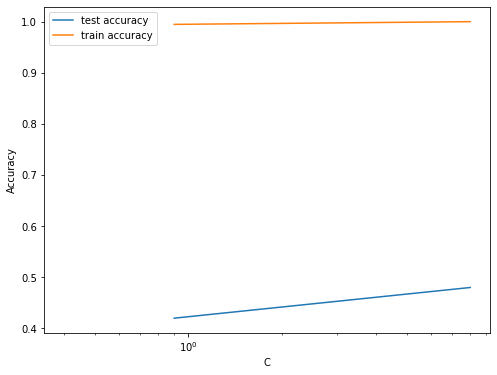

In [256]:
# Grid Search to find optimal C
#params = {"C": [0.6, 0.7, 0.8, 0.85, 0.86, 0.87, 0.89, 0.9, 1, 1.1]}
#params = {"C": [0.6, 0.7, 0.8, 0.85, 0.86, 0.87, 0.89, 0.9, 1, 1.1]}
params = {"C": [0.4, 0,5, 0,6, 0,7, 0,8, 0.9]}
model = SVC()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = params, 
                        scoring = 'accuracy', 
                        cv = cv_folds, 
                        verbose = 1, 
                        return_train_score=True) 
model_cv.fit(X_train, y_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

# plot of C versus train and test scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']
print("HOG - The highest test accuracy is {0} at C = {1}".format(round(best_score, 3), best_C))

In [37]:
# Chosen C value
C = 0.9

In [38]:
# Evaluation Metrics
def get_evaluation_metrics(cv_results, confusion_mat, print_statement, output_class_labels):
    # Accuracy
    print("Train Accuracy = {}".format(round(cv_results['train_accuracy'].mean(), 3)))
    print("Test Accuracy = {}".format(round(cv_results['test_accuracy'].mean(), 3)))

    # f1 score
    print("\nTrain f1 score = {}".format(round(cv_results['train_f1_score'].mean(), 3)))
    print("Test f1 score = {}".format(round(cv_results['test_f1_score'].mean(), 3)))

    # recall
    print("\nTrain recall = {}".format(round(cv_results['train_recall'].mean(), 3)))
    print("Test recall = {}".format(round(cv_results['test_recall'].mean(), 3)))

    # precision
    print("\nTrain precision = {}".format(round(cv_results['train_precision'].mean(), 3)))
    print("Test precision = {}".format(round(cv_results['test_precision'].mean(), 3)))
    
    # Confusion Matrix
    print("\nEvaluation Metrics:")
    print(print_statement)
    confusion_mat.columns = output_class_labels
    confusion_mat = confusion_mat.set_index([pd.Series(output_class_labels)])
    print("\n\nConfusion Matrix\n")
    print(confusion_mat)

In [39]:
### Model Scoring Parameters
scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'), 
           'f1_score' : make_scorer(f1_score, average = 'weighted')}

In [40]:
model = SVC(C)
cv_results = cross_validate(model, X_train, y_train, cv = cv_folds, scoring = scoring, return_train_score = True)
y_pred = cross_val_predict(model, X_train, y_train, cv = cv_folds)
confusion_mat = confusion_matrix(y_train, y_pred)

metrics = get_evaluation_metrics(cv_results, 
                         pd.DataFrame(confusion_mat),
                         print_statement = "Output Class labels: Pet, Play, Feed",
                         output_class_labels = ['Pet', 'Play', 'Feed'])

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass C=0.9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetr

/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saiyanaramisetty/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saiyanaramisetty/opt/anaco

Train Accuracy = 0.996
Test Accuracy = 0.49

Train f1 score = 0.996
Test f1 score = 0.49

Train recall = 0.996
Test recall = 0.49

Train precision = 0.996
Test precision = 0.49

Evaluation Metrics:
Output Class labels: Pet, Play, Feed


Confusion Matrix

      Pet  Play  Feed
Pet    12     0     7
Play    5     0     5
Feed    8     0    12


| HOG | Accuracy | F1 - Score | Precision | Recall |
| --- | --- | --- | --- | --- |
| Train | 26.2 | 10.9 | 26.2 | 6.9 |
| Test | 26.2 | 26.2 | 26.2 | 26.2 |

In [41]:
data = {
    "Feature" : ['HOG', 'HOG', 'SIFT', 'SIFT', 'HOG + SIFT', 'HOG + SIFT'],
    "Accuracy" : [75.9, 48, 98, 46.9, 99.6, 49],
    "Data": ['Train', 'Test','Train', 'Test','Train', 'Test']
}
df = pd.DataFrame(data)
print(df)

data = {
    "Feature" : ['HOG', 'SIFT', 'HOG + SIFT'],
    "Train_Accuracy" : [75.9, 98, 99.6],
    "Test_Accuracy" : [48, 46.9, 49]
}
df1 = pd.DataFrame(data)
print(df1)

      Feature  Accuracy   Data
0         HOG      75.9  Train
1         HOG      48.0   Test
2        SIFT      98.0  Train
3        SIFT      46.9   Test
4  HOG + SIFT      99.6  Train
5  HOG + SIFT      49.0   Test
      Feature  Train_Accuracy  Test_Accuracy
0         HOG            75.9           48.0
1        SIFT            98.0           46.9
2  HOG + SIFT            99.6           49.0


In [42]:
def annotate_count_plot_x(ax, col, x_diff, y_diff) :
    for p in ax.patches:
        height = int(p.get_height())
        x = p.get_x() + p.get_width() - x_diff
        y = p.get_y() + p.get_height() + y_diff
        if height < 50:
            ax.annotate(height, (x, y))

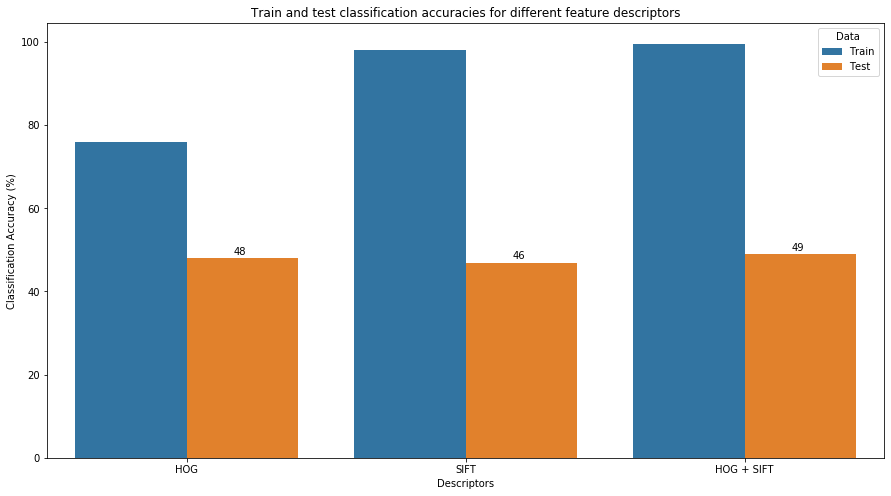

In [43]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'Feature', y = 'Accuracy', hue = 'Data', data = df)
plt.title('Train and test classification accuracies for different feature descriptors')
plt.xlabel('Descriptors')
plt.ylabel('Classification Accuracy (%)')
annotate_count_plot_x(ax, 'Feature', 0.23, 0.9)
plt.show()

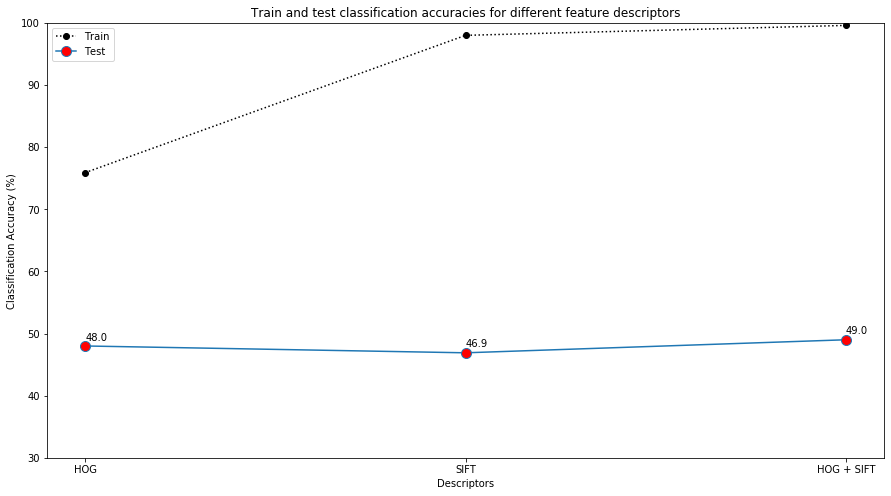

In [46]:
fig, ax = plt.subplots(figsize = (15,8))
plt.plot(df1['Feature'], df1['Train_Accuracy'], 'o:k')
plt.plot(df1['Feature'], df1['Test_Accuracy'], marker = 'o', ms = 10, mfc = 'r')
plt.title('Train and test classification accuracies for different feature descriptors')
plt.xlabel('Descriptors')
plt.ylabel('Classification Accuracy (%)')
plt.legend(['Train', 'Test'], loc = 'upper left')
for index in range(len(df1['Feature'])):
    ax.text(df1['Feature'][index], df1['Test_Accuracy'][index] + 0.9, df1['Test_Accuracy'][index])
ax.set_ylim([30, 100])
plt.show()